# COVID19db - Example 2 


This notebook demonstrates how to connect to COVID19db Postgres database and how to generate simple visualisaions.

In [12]:
import psycopg2
import pandas as pd
from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()
import matplotlib.pyplot as plt

# Connect to covid19db.org
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19'
)
cur = conn.cursor()
cur.execute("""SELECT i.* FROM
                (SELECT max(date) AS date, countrycode 
                FROM infections WHERE source='WRD_ECDC' AND countrycode<>''
                GROUP BY countrycode ) AS recent_data
            INNER JOIN infections AS i
            ON i.date=recent_data.date 
            AND i.countrycode = recent_data.countrycode
            AND i.adm_area_1 IS NULL
            ORDER by i.confirmed DESC
            """)
covid19_data = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
   

In [13]:
covid19_data.head()

,source,date,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,hospitalised,hospitalised_icu,quarantined
0,WRD_ECDC,2020-04-04,United_States_of_America,USA,None,None,None,None,277965,None,7157,None,None,None
1,WRD_ECDC,2020-04-04,Italy,ITA,None,None,None,None,119827,None,14681,None,None,None
2,WRD_ECDC,2020-04-04,Spain,ESP,None,None,None,None,117710,None,10935,None,None,None
3,WRD_ECDC,2020-04-04,China,CHN,None,None,None,None,82527,None,3330,None,None,None
4,WRD_ECDC,2020-04-04,Germany,DEU,None,None,None,None,79696,None,1017,None,None,None


In [14]:
import json
import geopandas as gpd

df = gpd.read_file('data/countries_geometries.geojson')
df.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,Fiji,FJI,...,피지,Fiji,Fidżi,Fiji,Фиджи,Fiji,Fiji,Fiji,斐濟,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,United Republic of Tanzania,TZA,...,탄자니아,Tanzania,Tanzania,Tanzânia,Танзания,Tanzania,Tanzanya,Tanzania,坦桑尼亚,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,Western Sahara,SAH,...,서사하라,Westelijke Sahara,Sahara Zachodnia,Saara Ocidental,Западная Сахара,Västsahara,Batı Sahra,Tây Sahara,西撒哈拉,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,Canada,CAN,...,캐나다,Canada,Kanada,Canadá,Канада,Kanada,Kanada,Canada,加拿大,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,United States of America,USA,...,미국,Verenigde Staten van Amerika,Stany Zjednoczone,Estados Unidos,Соединённые Штаты Америки,USA,Amerika Birleşik Devletleri,Hoa Kỳ,美国,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


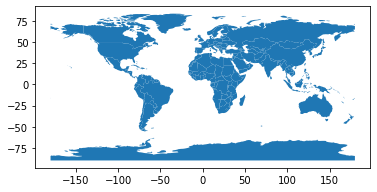

In [17]:
df.plot()

In [15]:
import folium
import numpy as np

world_map = folium.Map(location=[11,0], tiles="cartodbpositron", zoom_start=2, max_zoom = 6, min_zoom = 2)

folium.Choropleth(
    geo_data='data/countries_geometries.geojson',
     data=covid19_data,
     columns=['countrycode', 'confirmed'],
     key_on='feature.properties.ADM0_A3',
     fill_color='YlOrRd', 
     fill_opacity=0.7, 
     line_opacity=0.2,
     highlight=True,
     legend_name='COVID19 infected',
     nan_fill_color='black',
     nan_fill_opacity=0.4,
).add_to(world_map)


In [16]:
from IPython.core.display import HTML
HTML(world_map._repr_html_())